# What Zip Code in Iowa Should we open a new liquor store in?

**Problem Statement:** My goal is to use Iowa liquor store data collected in the 2015 fiscal year to determine where a good place to open a new liquor in 2016. Thus, the goal of this project is to determine which location in Iowa contributes to a liquor store's sales the most. The data provided has the indvisual sales for liquor stores in Iowa and includes the total sale (USD), volume of liqour sold, type of liquor sold, retail cost of the liquor,state cost of the liquor, various location data, and the date in which the sale was made. Each one of these attributes may or may not make a significant contribution to the total sale, however, the success of this study will be measured by determining if a specific location makes a significant controbution to the location's total sales, and if so, where the best location in Iowa would be to setup shop. To constrain a location's specific contribute to its sales, I will use an Elastic Net Linear Regression Model. Each zipcode will have it's own variable in the regression model, and I will determine the best location by which zipcode's coefficent is greatest. 

**EDA**

In [2]:
#Import necessary library
import matplotlib as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
#Load Data
df = pd.read_csv("/Users/Scott/dsi/DSI_Workspace/project-03/Iowa_Liquor_sales_sample_10pct.csv")
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [4]:
#droping rows with nans
df = df.dropna()
#remove dollar signs from monetary data
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]

for col in cols:
    df[col] = df[col].apply(lambda x: float(x[1:]))

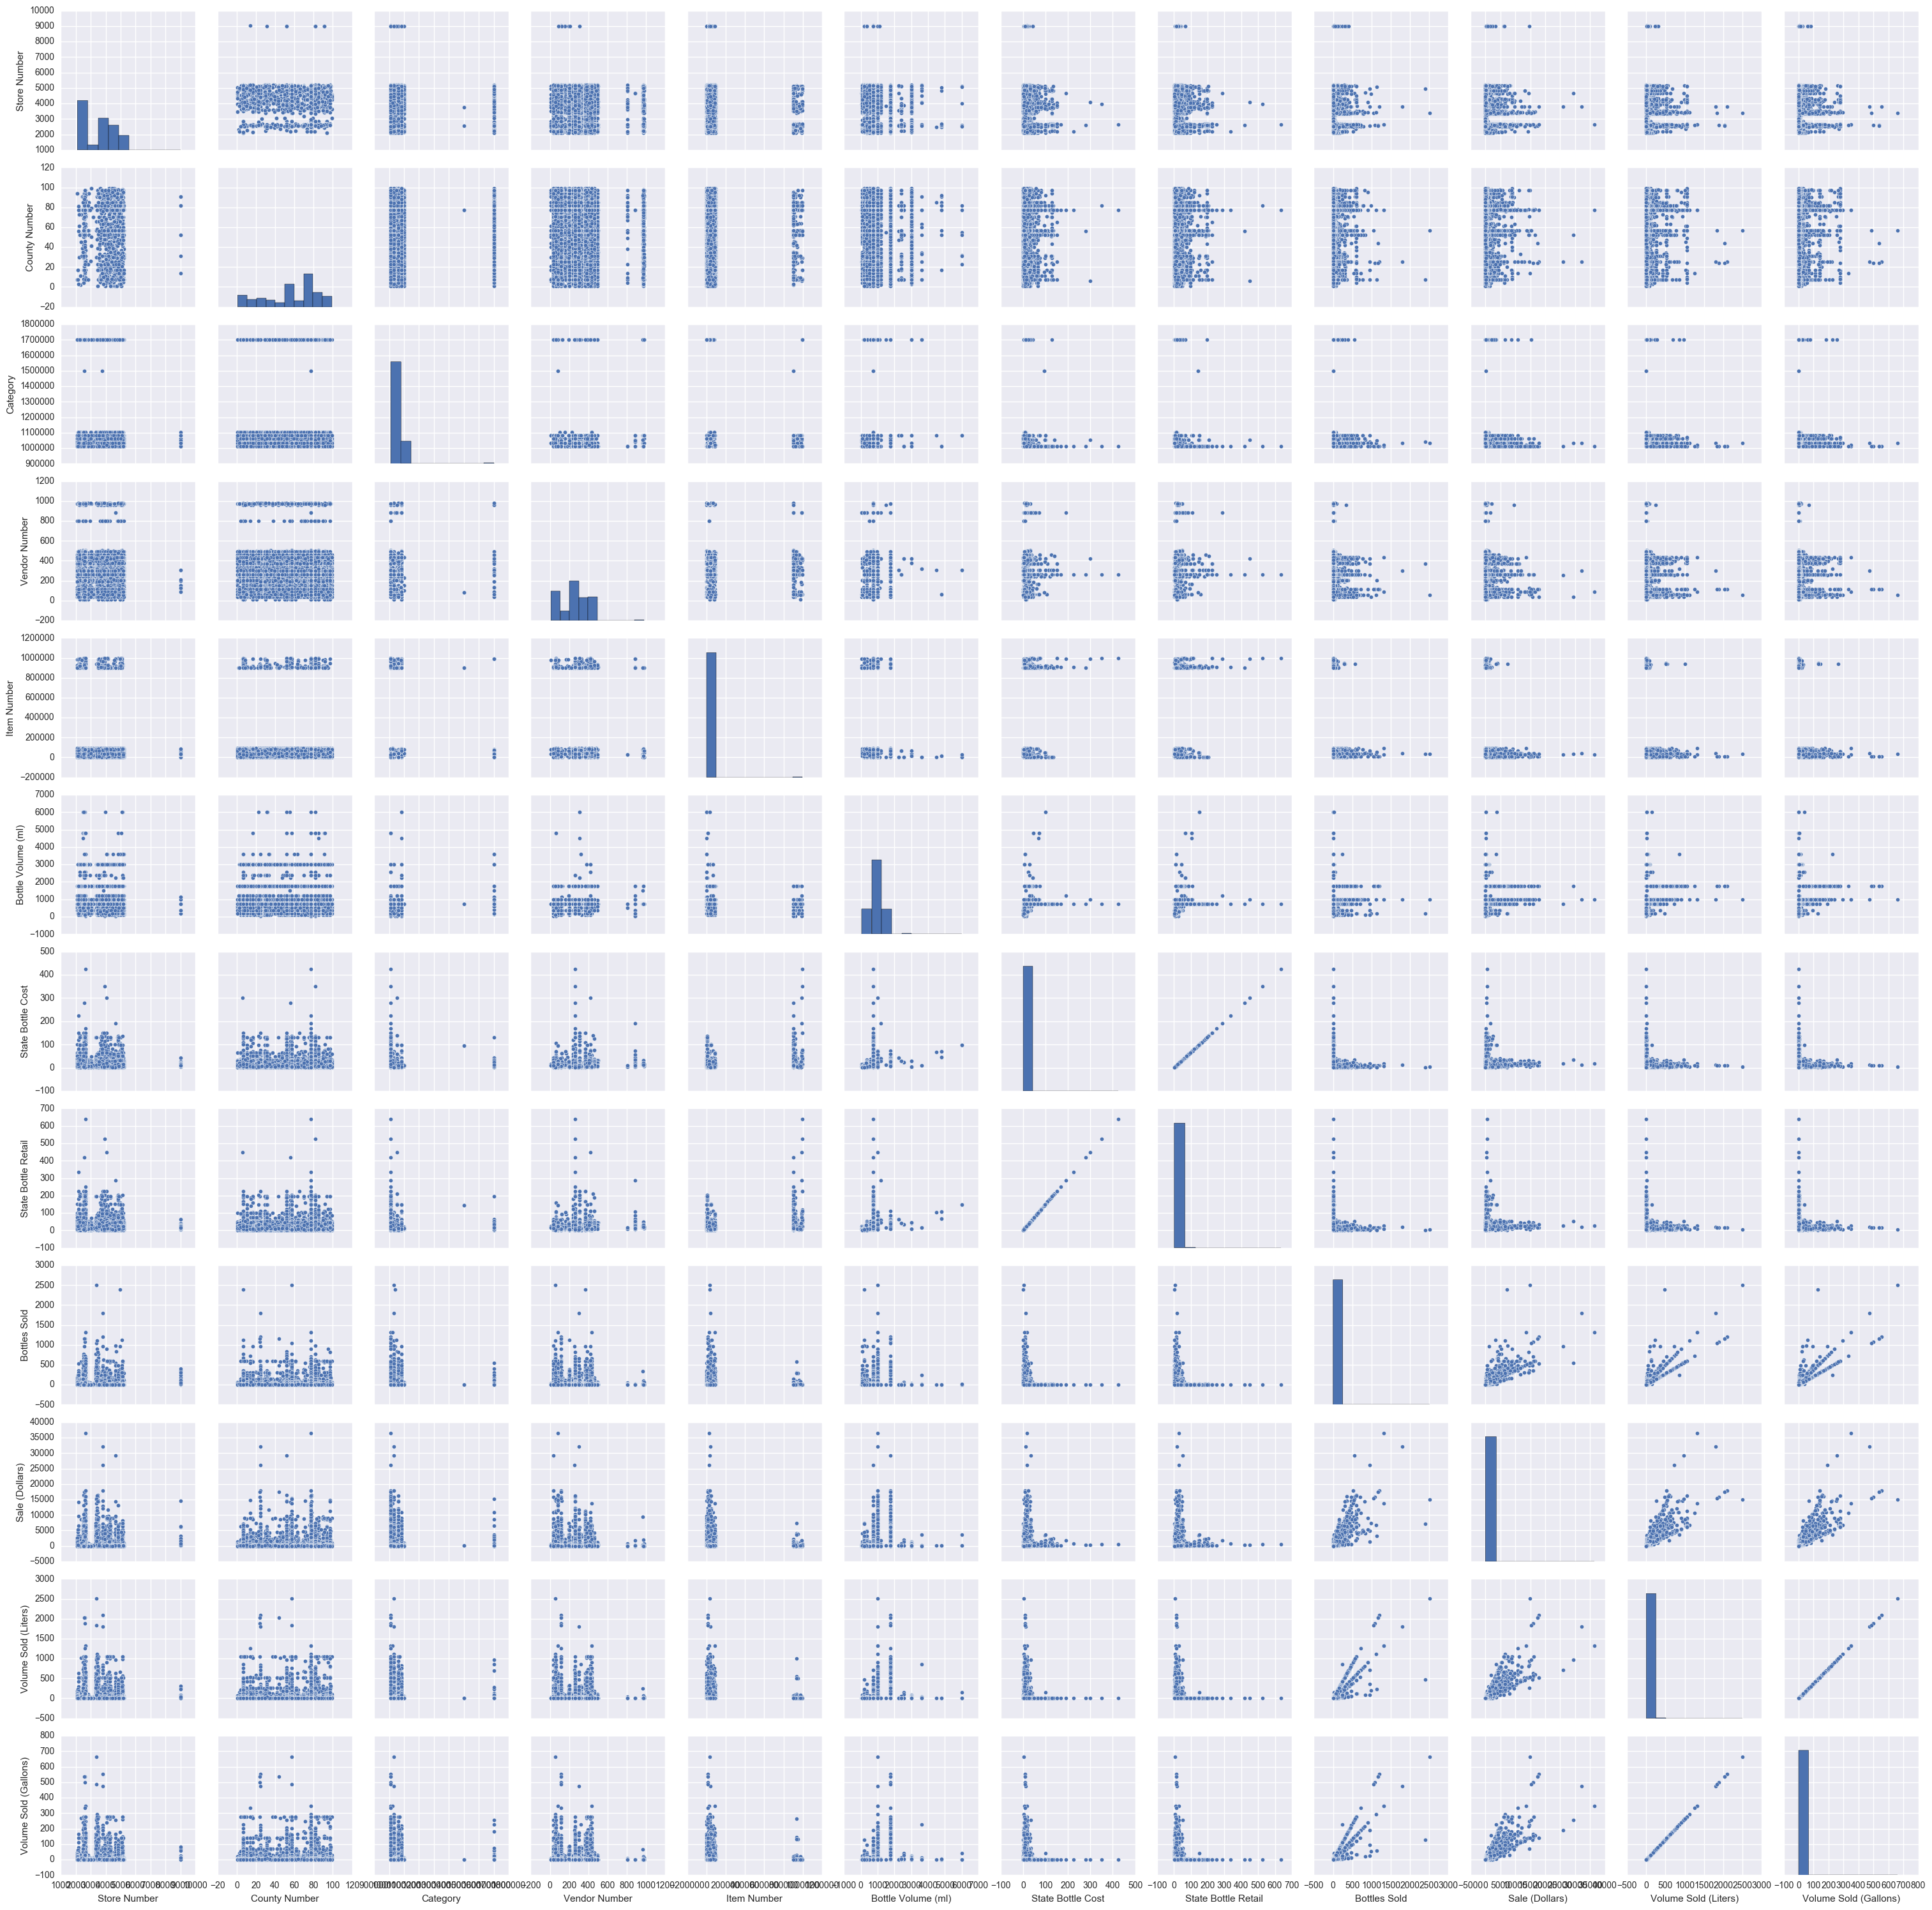

In [5]:
#plotting
sns.pairplot(df)

In [6]:
#Removing redundent Columns (analysis from pair plot)
del df["Category"] #Might care about category name to make category types
del df["Item Description"] #Will only care about general liquor types
del df["County"] # only care about zipcode
del df['City'] #only care about zip code
del df['Bottles Sold'] #bottles sold is a direct proxy for Sales, and we are interested in sales
del df['Volume Sold (Gallons)'] #volume is a proxy for sales
del df['Volume Sold (Liters)'] #volume is a proxy for sales
del df['Vendor Number'] #Don't need vendor Number
del df['County Number'] #only care about zipcode
del df['Item Number'] #Will use category Name
del df['Bottle Volume (ml)'] #should have nothing to do with sales

In [7]:
df.head()

,Date,Store Number,Zip Code,Category Name,State Bottle Cost,State Bottle Retail,Sale (Dollars)
0,11/04/2015,3717,50674,APRICOT BRANDIES,4.50,6.75,81.00
1,03/02/2016,2614,52807,BLENDED WHISKIES,13.75,20.63,41.26
2,02/11/2016,2106,50613,STRAIGHT BOURBON WHISKIES,12.59,18.89,453.36
3,02/03/2016,2501,50010,AMERICAN COCKTAILS,9.50,14.25,85.50
4,08/18/2015,3654,50421,VODKA 80 PROOF,7.20,10.80,129.60


The pair plot shows that our target (sales in dollars) has a lot of redundent features (proxys).  Also there are many different types of location data. Because zipcode offers the most specific information, I will be using that instead of County #, County, and City. None of the features appear to have a linear relationship with sales (other than direct proxys).

In [8]:
#Convert Dates
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

In [9]:
df.head()

,Date,Store Number,Zip Code,Category Name,State Bottle Cost,State Bottle Retail,Sale (Dollars)
0,2015-11-04,3717,50674,APRICOT BRANDIES,4.50,6.75,81.00
1,2016-03-02,2614,52807,BLENDED WHISKIES,13.75,20.63,41.26
2,2016-02-11,2106,50613,STRAIGHT BOURBON WHISKIES,12.59,18.89,453.36
3,2016-02-03,2501,50010,AMERICAN COCKTAILS,9.50,14.25,85.50
4,2015-08-18,3654,50421,VODKA 80 PROOF,7.20,10.80,129.60


In [10]:
#Find all the stores open in all of 2015
dates = df.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()
# Filter out stores that opened or closed throughout the year
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] 
                                              > upper_cutoff)
good_stores = dates[mask]["Store Number"]
df = df[df["Store Number"].isin(good_stores)]


#deleting date since all dates are within 2015
del df['Date']

In [11]:
#put alcholol into broad category, drop specific. 
def make_broad_category(x):
   x = x.lower()
   if 'liqueur' in x:
       return 'liqueur'
   elif 'whisk' in x or 'scotch' in x:
       return 'whiskey'
   elif 'vodka' in x:
       return 'vodka'
   elif 'gin' in x:
       return 'gin'
   elif 'tequila' in x:
       return 'tequila'
   elif 'schnapps' in x:
       return 'schnapps'
   elif 'rum' in x:
       return 'rum'
   elif 'brandies' in x:
       return 'brandy'
   elif 'creme' in x:
       return 'creme'
   elif 'beer' in x:
       return 'beer'
   elif 'amaretto' in x:
       return 'amaretto'
   elif 'anisette' in x:
       return 'anisette'
   else:
       return 'misc'
df['broad_category'] = df['Category Name'].map(make_broad_category)
del df['Category Name']
df.head()

/Users/Scott/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Store Number,Zip Code,State Bottle Cost,State Bottle Retail,Sale (Dollars),broad_category
0,3717,50674,4.50,6.75,81.00,brandy
1,2614,52807,13.75,20.63,41.26,whiskey
2,2106,50613,12.59,18.89,453.36,whiskey
3,2501,50010,9.50,14.25,85.50,misc
4,3654,50421,7.20,10.80,129.60,vodka


In [12]:
#create dummy variables for zip code, concat with original data frame
dum = pd.get_dummies(df['Zip Code'])
stores_with_dummies = pd.concat([df, dum], axis=1, join_axes=[df.index])
stores_with_dummies.head()

,Store Number,Zip Code,State Bottle Cost,State Bottle Retail,Sale (Dollars),broad_category,50002,50003,50006,50009,...,52776,52777,52778,52802,52803,52804,52806,52807,56201,712-2
0,3717,50674,4.50,6.75,81.00,brandy,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2614,52807,13.75,20.63,41.26,whiskey,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2106,50613,12.59,18.89,453.36,whiskey,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2501,50010,9.50,14.25,85.50,misc,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3654,50421,7.20,10.80,129.60,vodka,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
len(stores_with_dummies['Zip Code'])

256181

In [14]:
# add number of stores in zipcode as a feature. This takes a while
num_stores_in_zip = [np.sum(stores_with_dummies[str(code)]) for code in stores_with_dummies['Zip Code']]

In [15]:
stores_with_dummies['num_stores_in_zip'] = num_stores_in_zip

In [16]:
#Create dummy variables for broad_category
dum = pd.get_dummies(stores_with_dummies['broad_category'])
stores_with_dummies = pd.concat([stores_with_dummies, dum], axis=1, join_axes=[stores_with_dummies.index])
stores_with_dummies.head()
del stores_with_dummies['broad_category']

In [17]:
stores_with_dummies.head()

,Store Number,Zip Code,State Bottle Cost,State Bottle Retail,Sale (Dollars),50002,50003,50006,50009,50010,...,brandy,creme,gin,liqueur,misc,rum,schnapps,tequila,vodka,whiskey
0,3717,50674,4.50,6.75,81.00,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2614,52807,13.75,20.63,41.26,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2106,50613,12.59,18.89,453.36,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2501,50010,9.50,14.25,85.50,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3654,50421,7.20,10.80,129.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
#create target feature
target = stores_with_dummies['Sale (Dollars)']

In [19]:
del stores_with_dummies['Sale (Dollars)']

In [20]:
del stores_with_dummies['Store Number']
del stores_with_dummies['Zip Code']
#create feature data 
features  = stores_with_dummies

In [21]:
#train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [70]:
#standardize
#The rubric says to use cross validation, however, because SGD randomly shuffles your training set after each iteration
#doesn't that mean that there is no point in doing cross/k-fold validation of the training set? 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#regression, with grid search tuning for learning rate and l1 ratio
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
line = SGDRegressor(penalty='elasticnet',random_state=10000)
parameters = { 'alpha' : [1E-4, 1E-3, 1E-2, 0.1, 1, 10, 100, 1000], 'l1_ratio' : np.linspace(0,0.1,1)}
regress = GridSearchCV(line, parameters, scoring='r2')
regress.fit(X_train,y_train)

In [ ]:
print "training score",regress.score(X_train,y_train)
print "test score",regress.score(X_test,y_test)

The original goal of this project was to creat a linear model with zip code dummy variables as features. Here I created an elastic net regression using stocastic gradient decent. The elastic net is similar to OLS (Ordinary Least Squares) in that it minimizes the sum of the distance between the fitted line and the training data. However, the key difference is that it has two penalty parameters (absolute value of coefficents and the square of the coefficents) which flattens out the magnitude of a feature's coefficient. This means that only the most important features will have strong coefficients and the weaker features will be weighted towards zero.


As I suspected from my EDA, none of the variables (other than the obvious proxies) are linerally related to sales. However, we will still see which zip codes have the highest coefficient, just take these results with a rather large grain of salt.

In [ ]:
#make a new Series with coefficnents, sort by value
Col_coef = {col : regress.best_estimator_.coef_[i] for i,col in enumerate(stores_with_dummies.columns)}
S_coef = pd.Series(Col_coef,index=Col_coef.keys())
sorted_coef = S_coef.sort_values(ascending=False)
sorted_coef.head(20)

The highest coefficent in my model represents the zipcode which has the steepest positive linear relationship with total sales, and thus is a sensenible proxy for area strength in sales. 

According to the simualtion, the zip code 50320 has the highest coefficient in the model! However, I think this value is meaningless given the poor fit of my simualation. Regaurdless, I feel as though the logic is sound in this process in the sense that the store owner wants the location which brings most value to the new store and I tried to isolate that value. 

Given the model output, **I reccomend building a store in 50320, in Des Moines Iowa**. 

In order to improve this study, I suggest a non-linear model. Perhaps something like K-means clustering would be useful in order to group high sales with location. All in all, I do not think this is a regression problem, but a classification problem. Additional data, such as census data with density and age attributes, would also be useful in that we can then assess what types of people drink where and perhaps make a more confident reccomendation. 

See below for a detailed heat map of my model output.

In [84]:
#creating a heat map, have to do some cleanup

#getting all the zipcodes in a list
zipcodes = []
for label,value in zip(sorted_coef.index,sorted_coef.values):
    try:
        int(label)
        zipcodes.append((label,value))
    except:
        pass


In [85]:
#getting all the lat/lon data from pyzipcode and then appending the value for heat map
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()
data = []
for tup in zipcodes:
    try:
        zipcode = zcdb[tup[0]]
        lat = zipcode.latitude
        lon = zipcode.longitude
        value = tup[1]
        data.append(np.array([lat,lon,value]))
    except:
        pass

In [65]:
#make heatmap
import folium
from folium.plugins import HeatMap

m = folium.Map([41., -93.], tiles='stamentoner', zoom_start=8)

HeatMap(data).add_to(m)
m

Above is a heat map which shows the best/worst spots to open a new store according to my simulations, red is good blue is bad.